In [23]:
import os
from pathlib import Path
from datetime import datetime
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv() 
API_KEY = os.getenv("ALPHA_VANTAGE_KEY")
SYMBOL  = "CME"  

assert API_KEY, "Missing ALPHA_VANTAGE_KEY in .env"
    
ROOT = Path("..").resolve()  
RAW  = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

# ---------- request ----------
params = {
    "function": "TIME_SERIES_DAILY",    
    "symbol": SYMBOL,
    "outputsize": "compact",
    "apikey": API_KEY,
}

resp = requests.get("https://www.alphavantage.co/query", params=params, timeout=30)
resp.raise_for_status()
data = resp.json()

# Handle API errors / throttling messages
if "Error Message" in data:
    raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
if "Note" in data:
    raise RuntimeError(f"Alpha Vantage notice (likely rate limit): {data['Note']}")

ts_key = "Time Series (Daily)"
assert ts_key in data, f"Unexpected response keys: {list(data.keys())}"

# ---------- normalize ----------
df_api = pd.DataFrame(data[ts_key]).T
df_api.index.name = "date"
df_api = df_api.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low":  "low",
    "4. close": "close",
    "5. volume": "volume",
})

# types + sort
num_cols = ["open", "high", "low", "close", "volume"]
df_api[num_cols] = df_api[num_cols].apply(pd.to_numeric, errors="coerce")
df_api = df_api.reset_index()
df_api["date"] = pd.to_datetime(df_api["date"])
df_api = df_api.sort_values("date").reset_index(drop=True)

# ---------- validate ----------
assert not df_api.empty, "API returned empty dataset — check symbol or connectivity"
assert set(num_cols).issubset(df_api.columns), f"Missing cols: {set(num_cols) - set(df_api.columns)}"

# ---------- save ----------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
out_path = RAW / f"api_alphavantage_{SYMBOL}_{timestamp}.csv"
df_api.to_csv(out_path, index=False)
print("Saved:", out_path.as_posix())

df = df_api


Saved: /Users/yuyuezhu/bootcamp_carolina_zhu/project/data/raw/api_alphavantage_CME_20250826-1930.csv


In [25]:


# Statistical Summary
stats = df.describe().T
stats['median'] = df.median(numeric_only=True)
stats['skew'] = df.skew(numeric_only=True)
stats['kurt'] = df.kurtosis(numeric_only=True)
stats

,count,mean,min,25%,50%,75%,max,std,median,skew,kurt
date,100,2025-06-15 00:43:12,2025-04-03 00:00:00,2025-05-08 18:00:00,2025-06-14 12:00:00,2025-07-22 06:00:00,2025-08-26 00:00:00,NaN,NaN,NaN,NaN
open,100.0,273.9134,252.79,269.78,274.91,278.3775,289.38,7.757718,274.910,-0.578509,0.189106
high,100.0,276.421841,258.85,272.378,276.555,281.958725,290.79,7.340302,276.555,-0.349136,-0.213359
low,100.0,271.182818,248.53,267.00875,272.14,276.3875,287.17,8.166488,272.140,-0.664376,0.343280
close,100.0,274.0094,252.37,269.6875,274.73,278.025,290.71,7.889218,274.730,-0.541797,0.310367
volume,100.0,2424811.29,953432.0,1711727.5,2148812.5,2669800.25,10645719.0,1285193.074003,2148812.500,3.520783,17.427845


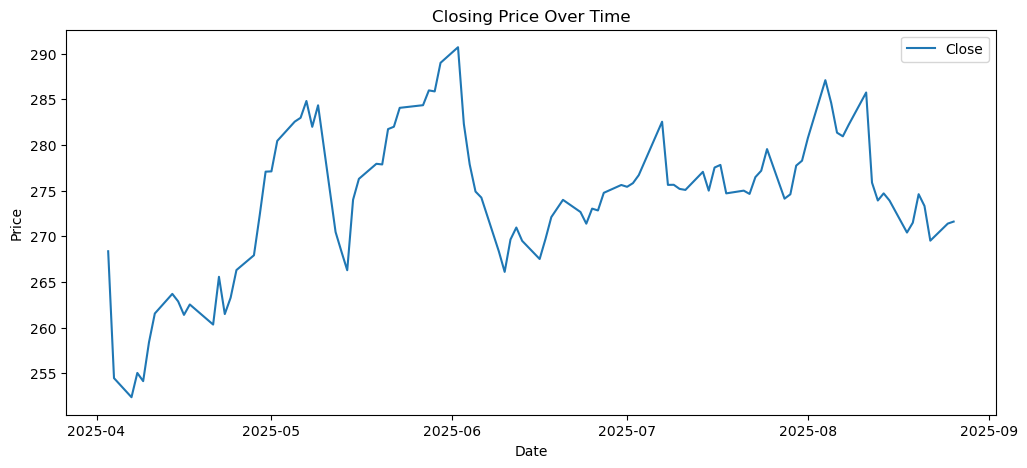

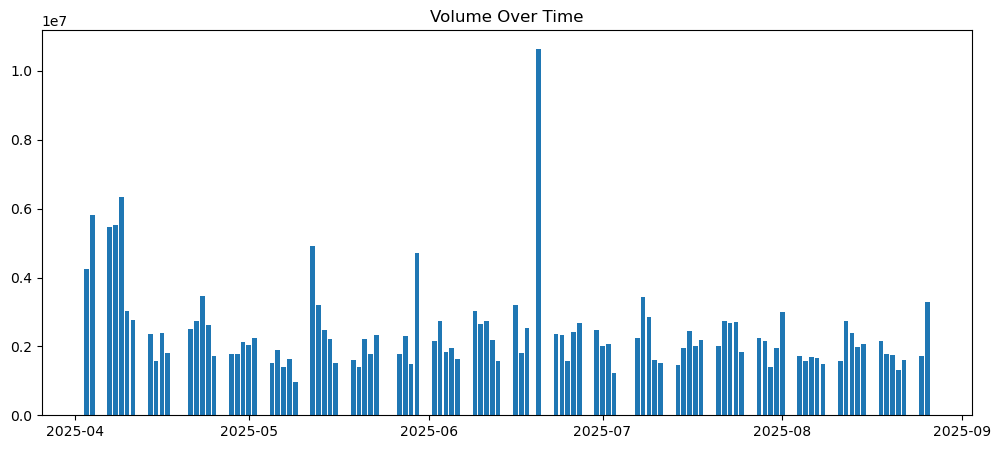

In [27]:
#Time Series Plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
plt.plot(df['date'], df['close'], label="Close")
plt.title("Closing Price Over Time")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
plt.bar(df['date'], df['volume'])
plt.title("Volume Over Time")
plt.show()

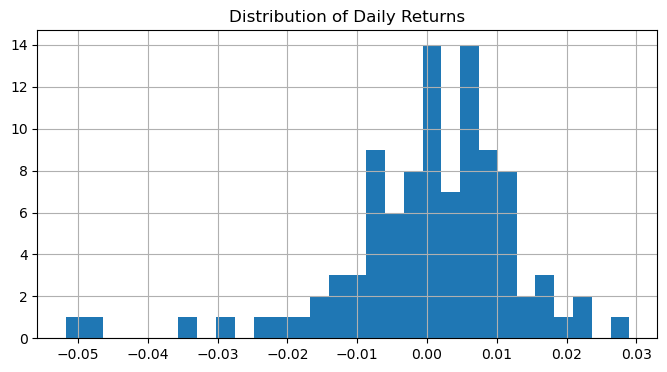

Text(0.5, 1.0, 'Price Distributions')

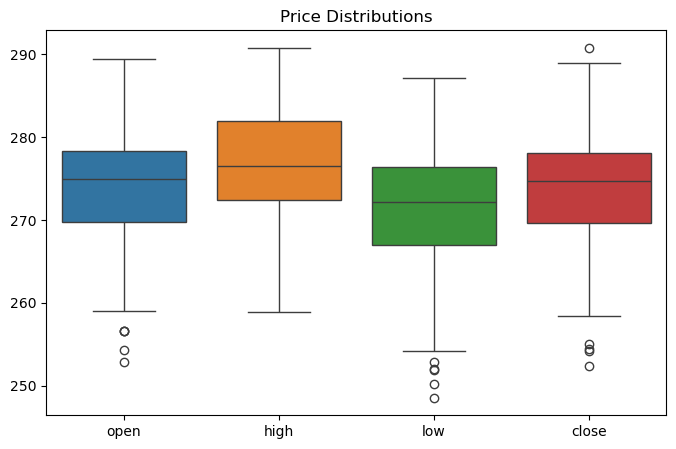

In [29]:
# Distribution

df['return'] = df['close'].pct_change()

df['return'].hist(bins=30, figsize=(8,4))
plt.title("Distribution of Daily Returns")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df[['open','high','low','close']])
plt.title("Price Distributions")